# Yagi et al. 
[Identification of distinct loci for de novo DNA methylation by DNMT3A and DNMT3B during mammalian development](https://www.nature.com/articles/s41467-020-16989-w)

In [1]:
alutil::register.source(here::here("code/init.R"))
rl <- alutil::rl
theme_set(tgppt::theme_arial(7))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘tgppt’


The following object is masked from ‘package:alutil’:

    vertical_labs



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


here() starts at /net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/track_stats.csv'



### DMRs

In [50]:
yagi_dmrs <- fread(here("data/yagi_dmrs.tsv")) %>% 
    filter(chrom %in% gintervals.all()$chrom) %>% 
    as_tibble() 

yagi_dmrs <- yagi_dmrs %>% 
    mutate(
        Yagi_3a = ifelse(type == "proA", meanMethy2, meanMethy1),
        Yagi_3b = ifelse(type == "proB", meanMethy2, meanMethy1)
    )

yagi_dmrs <- yagi_dmrs %>% 
    select(chrom, start, end, type, Yagi_3a, Yagi_3b)


head(yagi_dmrs)
nrow(yagi_dmrs)

chrom,start,end,type,Yagi_3a,Yagi_3b
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>
chr6,48387929,48389217,proA,0.05732420,0.6731291
chr3,55584536,55588340,proA,0.02412445,0.4470477
chr1,186549516,186554917,proA,0.02829836,0.5260327
chr4,135845931,135846972,proA,0.10997219,0.6153078
chr11,118941147,118943355,proA,0.04548308,0.6741248
chr7,77491664,77494580,proA,0.02552988,0.6597258


[1] 764

### Get Meissner data

In [51]:
md <- tribble(~track_name, ~sort, ~num,
    "Meissner_Nature_2017.Epi_Dnmt3a_1", "ko3a", 1,
    "Meissner_Nature_2017.Epi_Dnmt3a_2", "ko3a", 2,
    "Meissner_Nature_2017.Epi_Dnmt3a_4", "ko3a", 4,
    "Meissner_Nature_2017.Epi_Dnmt3a_5", "ko3a", 5,
    "Meissner_Nature_2017.Epi_Dnmt3a_6", "ko3a", 6,
    "Meissner_Nature_2017.Epi_Dnmt3b_1", "ko3b", 1,
    "Meissner_Nature_2017.Epi_Dnmt3b_2", "ko3b", 2,
    "Meissner_Nature_2017.Epi_Dnmt3b_3", "ko3b", 3,
    "Meissner_Nature_2017.Epi_Dnmt3b_4", "ko3b", 4,
    "Meissner_Nature_2017.Epi_Dnmt3b_5", "ko3b", 5,
    "Meissner_Nature_2017.Epi_Dnmt3b_6", "ko3b", 6,
    "Meissner_Nature_2017.Epi_WT_4", "wt", 4,
    "Meissner_Nature_2017.Epi_WT_5", "wt", 5,
    "Meissner_Nature_2017.Epi_WT_6", "wt", 6,
    "Meissner_Nature_2017.Epi_WT_7", "wt", 7) %>% 
        mutate(name = paste0(sort, "_", num))
        
m_all_epi6 <- gextract_meth(tracks = md$track_name, names=md$name, intervals=yagi_dmrs %>% select(chrom, start, end), extract_meth_calls = TRUE, iterator = yagi_dmrs %>% select(chrom, start, end)) %cache_df% here("output/meissner_epi_yagi_meth.tsv")  %>% as_tibble()    

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/meissner_epi_yagi_meth.tsv'



In [52]:
min_cov <- 10
m_epi6 <- m_all_epi6 %>% select(chrom, start, end)
for (g in unique(md$sort)){
        nms <- md %>% filter(sort == g) %>% pull(name)

        cov_col <- paste0(g, ".cov")
        meth_col <- paste0(g, ".meth")            

        m_epi6[[cov_col]] <- rowSums(m_all_epi6[, paste0(nms, ".cov")], na.rm=TRUE)
        m_epi6[[meth_col]] <- rowSums(m_all_epi6[, paste0(nms, ".meth")], na.rm=TRUE)
        
        m_epi6[[g]] <- ifelse(m_epi6[[cov_col]] >= min_cov, m_epi6[[meth_col]] / m_epi6[[cov_col]], NA)
    }
m_epi6 <- m_epi6 %>% select(-ends_with(".meth"), -ends_with(".cov"))  %cache_df% here("output/meissner_epi_yagi_meth_sum.tsv")

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/meissner_epi_yagi_meth_sum.tsv'



### Get MEEB data

In [70]:
m_meeb <- calc_eb_day0_to_day6_cpg_meth(intervals = yagi_dmrs %>% select(chrom, start, end), iterator =  yagi_dmrs %>% select(chrom, start, end), cache_fn = here("output/meeb_day0_to_day6_yagi_meth.tsv"), use_sort = FALSE, max_na = 100) %>% 
    select(-ends_with("cov"), -ends_with("meth")) %>% 
    select(-contains("_ko1"), -contains("_tko"), -starts_with("d0_"))

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/meeb_day0_to_day6_yagi_meth.tsv'



In [71]:
head(m_meeb)

chrom,start,end,d0S_3a,d1_3a,d2_3a,d3_3a,d4_3a,d5_3a,d6_3a,⋯,d4_3b,d5_3b,d6_3b,d0S_wt,d1_wt,d2_wt,d3_wt,d4_wt,d5_wt,d6_wt
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,14497410,14498475,0.66346154,NA,NA,NA,0.55855856,0.4925373,0.50000000,⋯,0.80373832,0.80000000,0.81250000,NA,NA,NA,0.8571429,0.8000000,0.79569892,0.82173913
chr1,21070410,21070719,0.31428571,NA,NA,NA,0.29113924,0.3614458,0.43801653,⋯,0.61538462,0.64406780,0.67832168,NA,NA,NA,NA,0.9523810,0.59183673,0.84771574
chr1,34163709,34164326,0.05769231,NA,NA,NA,0.08333333,0.1320755,0.17283951,⋯,0.13513514,0.22580645,0.22602740,NA,NA,NA,NA,0.1600000,0.46913580,0.36200000
chr1,38266943,38267649,0.29095853,0.1721992,0.1582915,0.2002882,0.25531915,0.5327103,0.67054908,⋯,0.25453654,0.29600000,0.33012628,0.3144775,0.1382979,0.1384615,0.2685560,0.3562982,0.81730769,0.74321230
chr1,38685382,38686284,0.41111111,NA,NA,NA,0.22222222,0.4615385,0.44520548,⋯,0.48913043,0.64444444,0.58235294,NA,NA,NA,NA,0.5666667,0.66666667,0.61437908
chr1,57032568,57032760,0.06779661,NA,NA,0.0000000,0.00000000,0.0000000,0.04635762,⋯,0.04395604,0.01923077,0.05128205,NA,NA,NA,NA,0.2666667,0.03921569,0.05809129


In [72]:
yagi_meth <- yagi_dmrs %>% 
    left_join(m_epi6) %>% 
    left_join(m_meeb)
head(yagi_meth)

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")



chrom,start,end,type,Yagi_3a,Yagi_3b,ko3a,ko3b,wt,d0S_3a,⋯,d4_3b,d5_3b,d6_3b,d0S_wt,d1_wt,d2_wt,d3_wt,d4_wt,d5_wt,d6_wt
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,48387929,48389217,proA,0.05732420,0.6731291,0.03305727,0.01935100,0.03128703,0.05240642,⋯,0.03423237,0.05020921,0.03491379,0.0733945,0.00000000,0.01075269,0.04411765,0.05958132,0.0718232,0.08210877
chr3,55584536,55588340,proA,0.02412445,0.4470477,0.03345408,0.02190160,0.05538695,0.22588832,⋯,0.21798030,0.21082621,0.25292056,0.1935484,0.11363636,0.18918919,0.22857143,0.27392739,0.3146667,0.33866951
chr1,186549516,186554917,proA,0.02829836,0.5260327,0.03760639,0.02147777,0.07845847,0.46839605,⋯,0.54364798,0.23013245,0.35954601,0.6337895,0.39802336,0.44246032,0.56379101,0.67888716,0.4138462,0.38639532
chr4,135845931,135846972,proA,0.10997219,0.6153078,0.11737341,0.04451465,0.21266968,0.12714157,⋯,0.10903427,0.08480000,0.08768536,0.1174785,0.05925926,0.05384615,0.12921348,0.19919786,0.1800766,0.32883390
chr11,118941147,118943355,proA,0.04548308,0.6741248,0.07684360,0.03943182,0.14754879,0.18901660,⋯,0.18750000,0.17412141,0.18470021,0.1296296,0.06000000,0.07317073,0.15789474,0.28443114,0.2222222,0.24428214
chr7,77491664,77494580,proA,0.02552988,0.6597258,0.00000000,0.04000000,NA,0.36474164,⋯,0.72745098,0.64102564,0.62837163,0.7187500,0.48275862,0.66666667,0.56410256,0.82432432,0.7349823,0.66535433


Warning message:
“Removed 4701 rows containing non-finite values (stat_boxplot).”


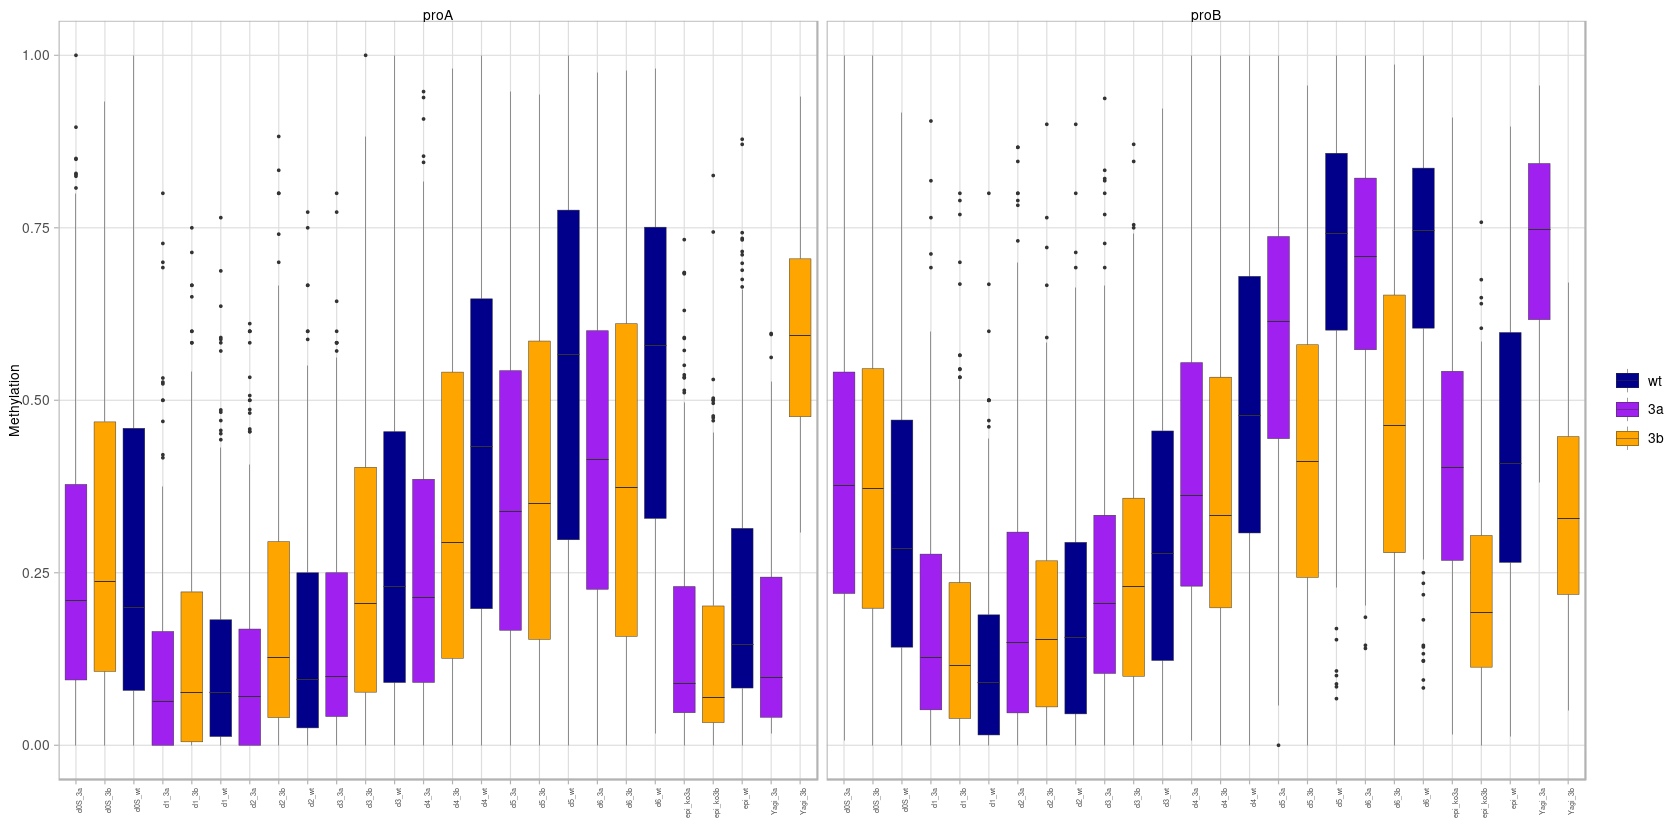

In [73]:
options(repr.plot.width = 14, repr.plot.height = 7)
line_colors <- c("wt" = "darkblue", "3a" = "purple", "3b" = "orange")
p_yagi <- yagi_meth %>%     
    select(chrom:end, type, Yagi_3a, Yagi_3b, epi_ko3a = ko3a, epi_ko3b = ko3b, epi_wt = wt, everything()) %>% 
    gather("samp", "meth", -(chrom:type)) %>%     
    mutate(samp = gsub("_all", "", samp)) %>% 
    mutate(line = case_when(
        grepl("3a", samp) ~ "3a",
        grepl("3b", samp) ~ "3b",
        grepl("wt", samp) ~ "wt"
    )) %>% 
    mutate(line = factor(line, levels = names(line_colors))) %>%
    ggplot(aes(x=samp, y=meth, fill=line)) + 
        geom_boxplot(outlier.size = 0, lwd = 0.1) + 
        xlab("") + 
        ylab("Methylation") + 
        scale_fill_manual("", values=line_colors) + 
        vertical_labs() + 
        theme(axis.text.x=element_text(size=4)) + 
        facet_wrap(~type)

p_yagi

    

In [74]:
tgppt::plot_gg_ppt(p_yagi, here("figures/Yagi.pptx"), width = 12, height=4, rasterize_plot = TRUE, sep_legend = TRUE, overwrite = TRUE)

Warning message:
“Removed 4701 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4701 rows containing non-finite values (stat_boxplot).”
